In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import interval

DATA_PATH = "data/generated/clean-entire_data.csv"
data = pd.read_csv(DATA_PATH).dropna()

In [6]:
features = ['Cell_Cycle',
       'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'TGF.Beta', 'RTK_RAS', 'TP53',
       'WNT', 'Hypoxia', 'SRC', 'ESR1', 'ERBB2']

features2 = ['B cells naive', 'B cells memory', 'Plasma cells',
       'T cells CD8', 'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils']

recauen_2anys = data[(data['RFS']<730) & (data['RFSE'] == 1)]
recauen_2anys = recauen_2anys[features2]
NOrecauen_5anys = data[(data['RFS']<1830) & (data['RFSE'] == 0)]
NOrecauen_5anys = NOrecauen_5anys[features2]

In [23]:
class Correlation():

    def __init__(self, df1, df2, d=False):
        self.R2 = df1
        self.NR5 = df2

        corr1 = df1.corr()
        corr2 = df2.corr()
        self.diff_matrix = np.absolute(corr1-corr2)

    def display(self, plot):
        if plot == "diff":
            cmap = sns.color_palette("rocket_r", as_cmap=True)
            mask = np.triu(np.ones_like(self.diff_matrix, dtype=bool))
            sns.heatmap(self.diff_matrix, mask=mask,cmap=cmap, vmin = 0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5})
        if plot == "diff_overlap":
            cmap = sns.color_palette("rocket_r", as_cmap=True)
            mask = np.triu(np.ones_like(self.diff_overlap_matrix, dtype=bool))
            sns.heatmap(self.diff_overlap_matrix, mask=mask,cmap=cmap, vmin = 0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5}) 

    def pairgrid(self, df, vars):
        matplotlib.pyplot.rcParams["axes.labelsize"] = 12
        g = sns.PairGrid(df[vars], diag_sharey=False)
        axes = g.axes
        g.map_upper(matplotlib.pyplot.scatter,  linewidths=1, 
                    edgecolor="w", s=90, alpha = 0.5)         
        g.map_diag(sns.kdeplot, lw = 4, legend=False)
        g.map_lower(sns.kdeplot, cmap="Blues_d")
        matplotlib.pyplot.show()

    def get_redundant_pairs(self, df):
        '''Get diagonal and lower triangular pairs of correlation matrix'''
        pairs_to_drop = set()
        cols = df.columns
        for i in range(0, df.shape[1]):
            for j in range(0, i+1):
                pairs_to_drop.add((cols[i], cols[j]))
        return pairs_to_drop

    def topNdiff(self, n=5):
        au_corr = self.diff_matrix.unstack()
        labels_to_drop = self.get_redundant_pairs(self.R2)
        au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
        print(au_corr[0:n])

    def pearson_corr(self, df, var1, var2, alpha, show_info):
        x = df[var1]
        y = df[var2]
        r, p = stats.pearsonr(x,y)
        r_z = np.arctanh(r)
        se = 1/np.sqrt(x.size-3)
        z = stats.norm.ppf(1-alpha/2)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        lo, hi = np.tanh((lo_z, hi_z))

        if show_info:
            print("--------------------------------")
            print("\n     Pearson's correlation       \n ")
            print("--------------------------------")
            print("corr = " + str(r))
            print("p-value = " + str(p))

            print("\n" + str(int((1-alpha)*100)) + " percent confidence interval:")

            print("[" + str(lo) + " , " + str(hi) + "]")
        return r, p, lo, hi

    def overlap(self, interval1, interval2):
        """
        Given [0, 4] and [1, 10] returns [1, 4]
        """
        if interval2[0] <= interval1[0] <= interval2[1]:
            start = interval1[0]
        elif interval1[0] <= interval2[0] <= interval1[1]:
            start = interval2[0]
        else:
            return (0, 0)

        if interval2[0] <= interval1[1] <= interval2[1]:
            end = interval1[1]
        elif interval1[0] <= interval2[1] <= interval1[1]:
            end = interval2[1]
        else:
            return (0, 0)

        return (start, end)

    def CI(self, var1='Hypoxia', var2='ERBB2', alpha=0.1, show_info=False):
        r1, p1, lo1, hi1 = self.pearson_corr(self.R2, var1, var2, alpha, show_info)
        r2, p2, lo2, hi2 = self.pearson_corr(self.NR5, var1, var2, alpha, show_info)
        
        start, end = self.overlap([lo1, hi1],[lo2, hi2])

        overlap_len = np.abs(end-start)
        total_len = np.abs(hi1-lo1) + np.abs(hi2-lo2) - overlap_len

        percentage_overlap = (overlap_len/total_len)*100
        percentage_overlap = str(round(percentage_overlap,2))+ '%'
        
        fig1, ax1 = plt.subplots() 
        ax1.set_ylim(0.5, 2.5)
        plt.suptitle(str(int((1-alpha)*100)) + "% Confidence Interval \n", y=1.05, fontsize=13)
        plt.title(var1 + " - " + var2, fontsize=12)

        plt.yticks(ticks=[1,1.5,2], labels=["Relapse 2 years","Overlap %","No Relapse 5years"])
        plt.vlines(hi1, ymin=0.85, ymax=1.15)
        plt.text(hi1-0.02, 0.70, str(round(hi1,2)), fontsize=10)
        plt.vlines(hi2, ymin=1.85, ymax=2.15)
        plt.text(hi2-0.02, 1.70, str(round(hi2,2)), fontsize=10)
        plt.vlines(lo1, ymin=0.85, ymax=1.15)
        plt.text(lo1-0.02, 0.70, str(round(lo1,2)), fontsize=10)
        plt.vlines(lo2, ymin=1.85, ymax=2.15)
        plt.text(lo2-0.02, 1.70, str(round(lo2,2)), fontsize=10)
        plt.hlines(1, xmin=lo1, xmax=hi1)
        plt.hlines(2, xmin=lo2, xmax=hi2)
        plt.text(r1, 1.2, "r : " + str(round(r1,2)), fontsize=12)
        plt.plot(r1, 1, 'bo')
        plt.text(r2, 2.2, "r : " + str(round(r2,2)), fontsize=12)
        plt.plot(r2, 2, 'bo')
        plt.barh(1.5, width=end-start, height=1,left=start, color = 'lavender')
        plt.text(((end+start)/2)-0.02, 1.5, percentage_overlap)

    def diff_overlap(self):
        features = ['B cells naive', 'B cells memory', 'Plasma cells',
       'T cells CD8', 'T cells CD4 naive', 'T cells CD4 memory resting',
       'T cells CD4 memory activated', 'T cells follicular helper',
       'T cells regulatory (Tregs)', 'T cells gamma delta', 'NK cells resting',
       'NK cells activated', 'Monocytes', 'Macrophages M0', 'Macrophages M1',
       'Macrophages M2', 'Dendritic cells resting',
       'Dendritic cells activated', 'Mast cells resting',
       'Mast cells activated', 'Eosinophils', 'Neutrophils']

        self.diff_overlap_matrix = pd.DataFrame(index=features, columns=features)
        self.diff_overlap_matrix = self.diff_overlap_matrix.fillna(0)
        
        for row, feature_row in enumerate(features): 
            for column, feature_column in enumerate(features): 
                if (row > column): 
                    r1, p1, lo1, hi1 = self.pearson_corr(self.R2, feature_row, feature_column, alpha=0.1, show_info=False)
                    r2, p2, lo2, hi2 = self.pearson_corr(self.NR5, feature_row, feature_column, alpha=0.1, show_info=False)
        
                    start, end = self.overlap([lo1, hi1],[lo2, hi2])

               
                    overlap_len = np.abs(end-start)
                    total_len = np.abs(hi1-lo1) + np.abs(hi2-lo2) - overlap_len

                    percentage_overlap = (overlap_len/total_len)*100

                    self.diff_overlap_matrix.loc[feature_row,feature_column] = percentage_overlap
        
        cmap = sns.color_palette("rocket", as_cmap=True)
        mask = np.triu(np.ones_like(self.diff_overlap_matrix, dtype=bool))
        sns.heatmap(self.diff_overlap_matrix, mask=mask,cmap=cmap, vmin = 0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5, 'label': '% Overlap'})
        return self.diff_overlap_matrix

In [24]:
correlation = Correlation(recauen_2anys,NOrecauen_5anys)

In [28]:
diff_overlap = correlation.topNdiff(n=10)

NK cells activated         Macrophages M0                0.463964
Mast cells activated       Neutrophils                   0.429916
NK cells resting           Macrophages M0                0.376433
                           Eosinophils                   0.357482
Plasma cells               T cells CD4 memory resting    0.329994
T cells follicular helper  Neutrophils                   0.314715
Monocytes                  Dendritic cells resting       0.300099
T cells gamma delta        Dendritic cells activated     0.298915
Plasma cells               T cells regulatory (Tregs)    0.294124
T cells follicular helper  Eosinophils                   0.278817
dtype: float64


In [98]:
correlation.diff_matrix

,Cell_Cycle,HIPPO,MYC,NOTCH,NRF2,PI3K,TGF.Beta,RTK_RAS,TP53,WNT,Hypoxia,SRC,ESR1,ERBB2
Cell_Cycle,0.000000,0.059541,0.184834,0.101958,0.011999,0.110858,0.089458,0.091878,0.012380,0.069390,0.091663,0.080373,0.095448,0.089379
HIPPO,0.059541,0.000000,0.018452,0.044420,0.234022,0.116485,0.171135,0.055886,0.187155,0.011237,0.045447,0.055836,0.207778,0.294830
MYC,0.184834,0.018452,0.000000,0.134394,0.130303,0.023141,0.122923,0.038746,0.046455,0.138119,0.083113,0.177614,0.077956,0.097681
NOTCH,0.101958,0.044420,0.134394,0.000000,0.079893,0.138093,0.064162,0.004172,0.114540,0.034073,0.084306,0.183648,0.123010,0.036111
NRF2,0.011999,0.234022,0.130303,0.079893,0.000000,0.204788,0.152629,0.002270,0.063617,0.177608,0.001009,0.055239,0.132448,0.006053
PI3K,0.110858,0.116485,0.023141,0.138093,0.204788,0.000000,0.303510,0.000995,0.042367,0.026056,0.072697,0.078265,0.034131,0.011789
TGF.Beta,0.089458,0.171135,0.122923,0.064162,0.152629,0.303510,0.000000,0.021925,0.096585,0.109454,0.313818,0.163277,0.102490,0.158619
RTK_RAS,0.091878,0.055886,0.038746,0.004172,0.002270,0.000995,0.021925,0.000000,0.235031,0.141855,0.018231,0.213978,0.150296,0.136045
TP53,0.012380,0.187155,0.046455,0.114540,0.063617,0.042367,0.096585,0.235031,0.000000,0.015902,0.047968,0.082019,0.164717,0.179943
WNT,0.069390,0.011237,0.138119,0.034073,0.177608,0.026056,0.109454,0.141855,0.015902,0.000000,0.019197,0.266156,0.159714,0.254444


In [375]:
correlation.topNdiff(n=10)

TGF.Beta  Hypoxia     0.313818
PI3K      TGF.Beta    0.303510
HIPPO     ERBB2       0.294830
WNT       SRC         0.266156
          ERBB2       0.254444
ESR1      ERBB2       0.236418
RTK_RAS   TP53        0.235031
HIPPO     NRF2        0.234022
RTK_RAS   SRC         0.213978
HIPPO     ESR1        0.207778
dtype: float64


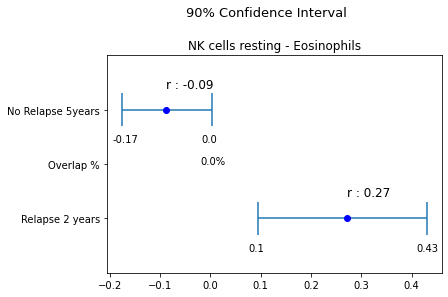

In [32]:
correlation.CI('NK cells resting','Eosinophils', show_info=False)

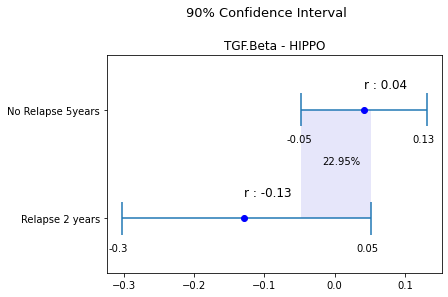

In [367]:
correlation.CI('TGF.Beta','HIPPO', show_info=False)